### Some Imports

Lets setup the notebook

In [6]:
from ipywidgets import *
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook
%matplotlib notebook

In [22]:
import taurex

And lets disable logging

In [23]:
taurex.log.disableLogging()

### Loading cross-sections

We need to point TauREx3 to our cross-sections. This is handled by the caching classes. Once a cross-section is loaded it does not need to be loaded again.
First lets import the classes:

In [9]:
from taurex.cache import OpacityCache,CIACache

Now lets point the xsection and cia cachers to our files:

In [11]:
OpacityCache().set_opacity_path("C:/Users/Ahmed/Documents/TaurexData/xsec/TauRex_sampled_xsecs_R10000_0.3-15")
CIACache().set_cia_path("C:/Users/Ahmed/Documents/TaurexData/cia/hitran")

TauREx3 is now ready to use them! For fun lets, try grabbing the H2O cross-section and plotting it. First tell the OpacityCache function to grab it:

In [19]:
h2o = OpacityCache()['H2O']

Doing this the first time it slow. But repeated calls are super fast.  We can use the opacity function to 
compute the cross section for a temperature and pressure:

In [20]:
h2o.opacity(temperature=600.0,pressure=1e0)

array([4.03319460e-31, 3.42237117e-31, 3.34873403e-31, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

How about we plot it instead?

<IPython.core.display.Javascript object>


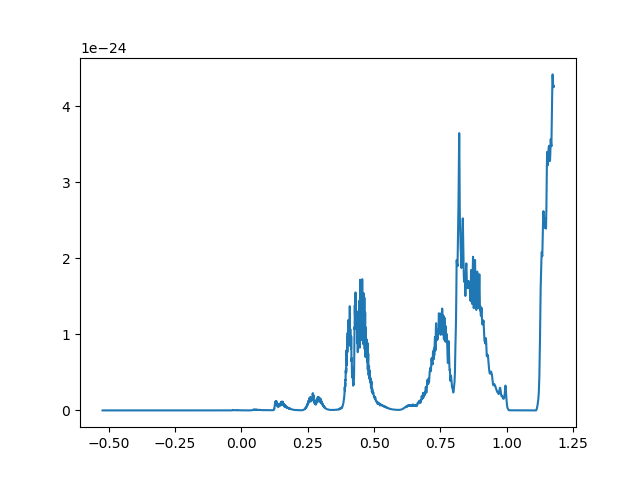

interactive(children=(FloatSlider(value=1500.0, description='temperature', max=2000.0, min=800.0), FloatSlider…

In [21]:


fig = plt.figure()
ax = fig.add_subplot(1,1,1)

xsec, = ax.plot(np.log10(10000/h2o.wavenumberGrid),h2o.opacity(800,1e0))

def update_cross(temperature=1500.0,pressure=-4):

    xsec.set_ydata(h2o.opacity(temperature,10**pressure))
    ax.relim();
    ax.autoscale_view()
    fig.canvas.draw()

interact(update_cross,temperature=(800.0,2000.0),pressure=(-1.0,10.0));

Pretty cool right?

In [ ]:
from taurex.model import TransmissionModel
from taurex.contributions import *

from taurex.data import Planet
from taurex.data.profiles.chemistry import TaurexChemistry
from taurex.data.profiles.chemistry import ConstantGas

### Setting up the model

Now we need to setup our forward model. Lets create a temperature profile, we will use the isothermal profile but other brands are available:

In [24]:
from taurex.data.profiles.temperature import Isothermal
isothermal = Isothermal(iso_temp=1500.0)

In [17]:

planet = Planet(radius=1.1,mass=1.1)

In [18]:
chemistry = TaurexChemistry(n2_mix_ratio=0,he_h2_ratio=0.15676)

h2o = ConstantGas('H2O',mix_ratio=1e-4)

chemistry.addGas(h2o)
chemistry.addGas(ConstantGas('CH4',mix_ratio=1e-5))


In [19]:
tm = TransmissionModel(planet=planet,temperature_profile=isothermal,chemistry=chemistry,
                        atm_min_pressure=1e-4,atm_max_pressure=1e6,nlayers=100)

tm.add_contribution(AbsorptionContribution())
tm.add_contribution(CIAContribution(cia_pairs=['H2-H2','H2-He']))
tm.build()

In [20]:
native_grid = tm.nativeWavenumberGrid

<IPython.core.display.Javascript object>


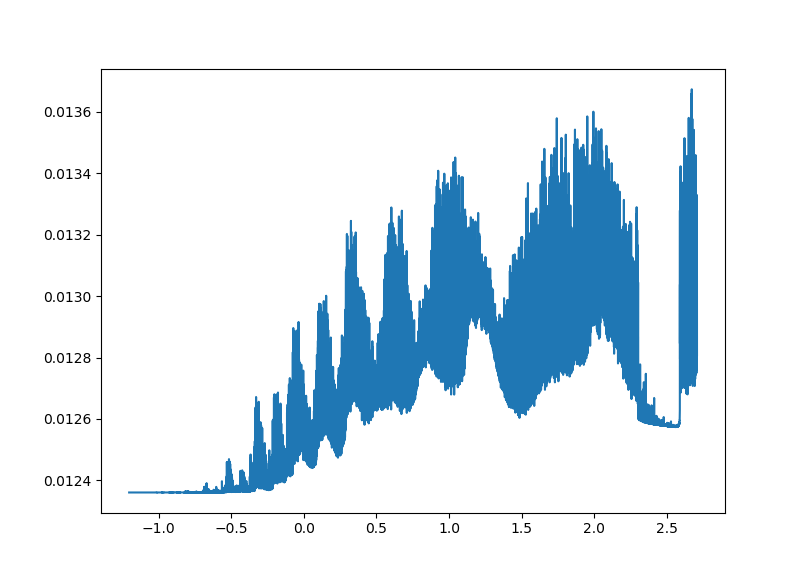

In [21]:
fig = plt.figure()
plt.plot(np.log(10000/native_grid),tm.model(return_contrib=False)[0])
plt.show()

<IPython.core.display.Javascript object>


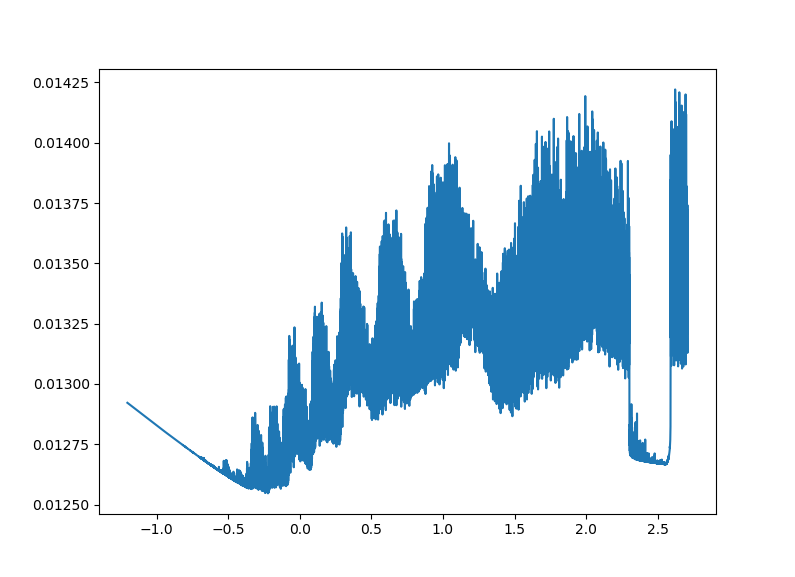

interactive(children=(Checkbox(value=False, description='Rayleigh'), Output()), _dom_classes=('widget-interact…

interactive(children=(FloatSlider(value=1500.0, description='temperature', max=2000.0, min=800.0), FloatSlider…

In [22]:

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

model, = ax.plot(np.log(10000/native_grid),tm.model(return_contrib=False)[0])


@interact
def rayleighchanged(b=Checkbox(False, description='Rayleigh')):
    global tm
    tm = TransmissionModel(planet=planet,temperature_profile=isothermal,chemistry=chemistry,
                    atm_min_pressure=1e-4,atm_max_pressure=1e6,nlayers=100)

    tm.add_contribution(AbsorptionContribution())
    tm.add_contribution(CIAContribution(cia_pairs=['H2-H2','H2-He']))
    if b:
        tm.add_contribution(RayleighContribution())
        
    tm.build()
    model.set_ydata(tm.model(return_contrib=False)[0])
    ax.relim();
    ax.autoscale_view()
    fig.canvas.draw()




def update_model(temperature=1500.0,h2o_mix=-4):
    isothermal.isoTemperature = temperature
    tm['H2O'] = 10**h2o_mix
    model.set_ydata(tm.model(return_contrib=False)[0])
    ax.relim();
    ax.autoscale_view()
    fig.canvas.draw()

interact(update_model,temperature=(800.0,2000.0),h2o_mix=(-7.0,-2.0));
